# SVM with hinge loss and subdifferential descent

A problem of the form is solved:
$$
L(w) = \frac{\lambda}{2} \lVert w \rVert^2 + \frac{1}{N} \sum_{i=1}^{N} \max \left\{ 0,\ 1 - y_i w^T x_i \right\}.
$$
It can be shown that the subgradient
$$
g(w) = \lambda w + \frac{1}{N} \sum_{i=1}^{N}
\begin{cases}
  -y_i x_i, & \text{if  } \  y_i w^T x_i < 1, \\
  0, & \text{otherwise}.
\end{cases}
$$
The function $\ell_i(w) = \max\left\{ 0,\ 1 - y_i w^T x_i \right\}$ is called hinge loss.

Let's generate data for classification:

In [22]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
N = 100  # number of objects
X1 = np.random.randn(N//2, 2) + np.array([2, 2])
X2 = np.random.randn(N//2, 2) + np.array([-2, -2])

X = np.vstack([X1, X2])          # the matrix of objects x features
y = np.hstack([np.ones(N//2), -np.ones(N//2)])  # class labels: +1, -1

# Let's mix everything together for clarity
perm = np.random.permutation(N)
X = X[perm]
y = y[perm]

Objective (hinge loss):

In [23]:
def hinge_svm_objective(w, X, y, lambd):
    """
    Returns the value of the functional:
      L(w) = (lambda/2)*||w||^2 + (1/N)*sum( max(0, 1 - y_i * w^T x_i) ).
    """
    margins = 1 - y * (X.dot(w))
    hinge_losses = np.maximum(0, margins)
    return (lambd/2)*np.sum(w**2) + np.mean(hinge_losses)

The subgradient of the functional:

In [24]:
def hinge_svm_subgradient(w, X, y, lambd):
    """
    Returns the subgradient g(w) for:
      g(w) = lambda*w + (1/N)*sum( -y_i*x_i, если y_i*w^T x_i < 1 ).
    """
    N = X.shape[0]
    margins = 1 - y * (X.dot(w))
    active_mask = (margins > 0).astype(float)  # где hinge>0
    
    # Суммируем -y_i*x_i по всем активным (margin>0)
    grad_hinge = -(y * active_mask)[:, np.newaxis] * X
    grad_hinge = grad_hinge.mean(axis=0)
    
    g = lambd*w + grad_hinge
    return g

Subgradient descent implementation:

In [25]:
def subgradient_descent(
    X, y, lambd=0.01, 
    max_iter=150, 
    step_rule='constant', 
    c=1.0,
    f_star=0.0
):
    """
    Subgradient descent for SVM with hinge loss:
    
    Параметры:
      X, y       : selection
      lambd      : the regularization coefficient
      max_iter   : iteration number
      step_rule  : step selection strategy:
                     - 'constant'       -> alpha_k = c
                     - '1_over_k'       -> alpha_k = c/k
                     - '1_over_sqrt_k'  -> alpha_k = c/sqrt(k)
                     - 'polyak'         -> alpha_k = (f(w_k) - f_star)/||g_k||^2
      c          : constant for the step (used in all but not for 'polyak')
      f_star     : estimated minimum (for polyak)
    
    Возвращает:
      w_history   : the list of vectors w at each iteration
      loss_history: the list of values of the functional L(w) at each iteration
    """
    w = np.zeros(X.shape[1])
    w_history = [w.copy()]
    loss_history = [hinge_svm_objective(w, X, y, lambd)]
    
    for k in range(1, max_iter+1):
        g = hinge_svm_subgradient(w, X, y, lambd)
        loss_current = hinge_svm_objective(w, X, y, lambd)
        
        # Выбираем шаг
        if step_rule == 'constant':
            alpha = c
        elif step_rule == '1_over_k':
            alpha = c / k
        elif step_rule == '1_over_sqrt_k':
            alpha = c / np.sqrt(k)
        elif step_rule == 'polyak':
            # Polyak's step: (f(w) - f_star) / ||g||^2 (with a zero cut-off from below)
            denom = np.dot(g, g)
            if denom < 1e-15:
                alpha = 0.0
            else:
                alpha = (loss_current - f_star) / denom
                alpha = max(alpha, 0.0)  # чтобы шаг не был отрицательным
        else:
            raise ValueError("Неизвестная стратегия шага")
        
        # Update w
        w = w - alpha*g
        
        w_history.append(w.copy())
        loss_history.append(hinge_svm_objective(w, X, y, lambd))
    
    return w_history, loss_history

Running an experiment for different step rules:

In [26]:
max_iter = 50
lambd = 0.01

# For example Polyak step size will be considered f^*=0 (simplification for demonstration)
f_star_demo = 0.0

strategies = {
    'constant':         1.5,   # constant step size
    '1_over_k':         5.0,   # for 1/k
    '1_over_sqrt_k':    5.0,   # for 1/sqrt(k)
    'polyak':           None   # for Polyak is None
}

results = {}
for rule, c_val in strategies.items():
    w_hist, loss_hist = subgradient_descent(
        X, y, lambd=lambd, max_iter=max_iter,
        step_rule=rule,
        c=c_val if c_val is not None else 1.0,
        f_star=f_star_demo
    )
    results[rule] = (w_hist, loss_hist)

Vizualization:

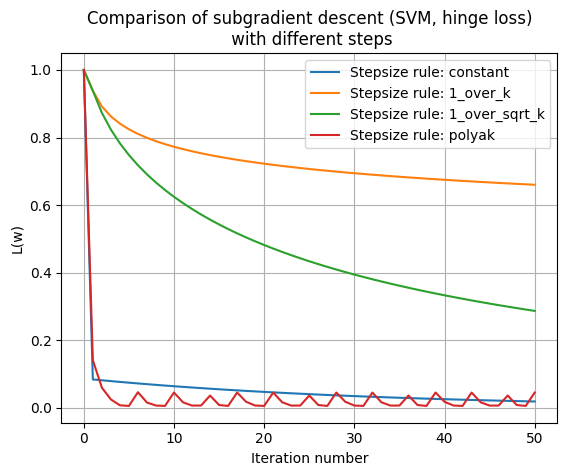

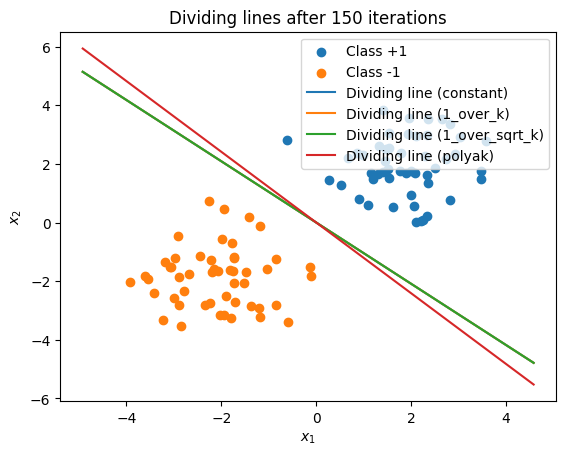

In [28]:
plt.figure()
for rule in strategies.keys():
    loss_hist = results[rule][1]
    plt.plot(loss_hist, label=f"Stepsize rule: {rule}")
plt.xlabel("Iteration number")
plt.ylabel("L(w)")
plt.title("Comparison of subgradient descent (SVM, hinge loss)\n with different steps")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(X[y==1, 0], X[y==1, 1], label="Class +1")
plt.scatter(X[y==-1, 0], X[y==-1, 1], label="Class -1")

x_vals = np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200)
for rule in strategies.keys():
    w_final = results[rule][0][-1]
    if abs(w_final[1]) < 1e-15:
        x_const = -0.0
        plt.plot([x_const, x_const], [X[:,1].min()-1, X[:,1].max()+1],
                 label=f"Dividing line ({rule})")
    else:
        y_vals = -(w_final[0]/w_final[1]) * x_vals
        plt.plot(x_vals, y_vals, label=f"Dividing line ({rule})")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Dividing lines after 150 iterations")
plt.legend()
plt.show()